# Question Answers Generations Model

In [1]:
# Dependencies
import pandas as pd
import polars as pl
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model , optimizers
from tensorflow.keras.layers import Attention, LSTM, Bidirectional, Dense, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, Dropout, concatenate, Concatenate

import seaborn as sns
import matplotlib.pyplot as plt

# !pip install tensorflow_hub
import tensorflow_hub as hub
import os
import re
import json

print('Tf version: ',tf.__version__)
print('GPU: ', len(tf.config.list_physical_devices('GPU')))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["TFHUB_CACHE_DIR"] = './tmp/tfhub'

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
None
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)
print(config)

def download_USEncoder():

    print('downloading universal sentence encoder...')
    !wget https://storage.googleapis.com/tfhub-modules/google/universal-sentence-encoder/4.tar.gz
    print('Downloaded universal sentence encoder.')
    # Extracting
    try:
        !mkdir universal_sentence_encoder
        print('Extracting universal sentence encoder....')
        ! tar -xf 4.tar.gz --directory ./universal_sentence_encoder
        print('Extracted.')
    except Exception as e:
        print(e)


2023-01-25 16:43:24.086099: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 16:43:24.593697: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-25 16:43:25.828709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/t/miniconda3/envs/tf/lib/
2023-01-25 16:43:25.828799: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.

Tf version:  2.10.0
GPU:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
None


2023-01-25 16:43:28.290882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 16:43:28.336493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 16:43:28.336858: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# get the data
df = pl.read_csv('dataset/train_data_cleaned.csv')
df.shape, df.to_pandas().info(), type(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86821 entries, 0 to 86820
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0                 86821 non-null  int64 
 1   title         86821 non-null  object
 2   context       86821 non-null  object
 3   questions     86821 non-null  object
 4   final_answer  86821 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.3+ MB


((86821, 5), None, polars.internals.dataframe.frame.DataFrame)

In [3]:
df.sample(5)

,title,context,questions,final_answer
i64,str,str,str,str
78308,"""A_cappella""","""The Swingle Si...","""What was used ...","""a four-track r..."
74480,"""Carnival""","""The Strumica C...","""How long has t...","""since at least..."
129662,"""Hunting""","""A variety of i...","""Where does the...","""in tented camp..."
25465,"""Brain""","""Physiologicall...","""Reflexes only ...","""spinal cord or..."
107916,"""Antenna_(radio...","""Recall that a ...","""How is this pr...","""balun"""


In [4]:
# null check
df.null_count()

,title,context,questions,final_answer
u32,u32,u32,u32,u32
0,0,0,0,0


In [5]:
#drop nulls
df.drop_nulls()
print('Null removed')

Null removed


# Here we will add a new columns to data which can be a switch wheather we want question and ans from model or just answers

In [6]:
modes = {
    'find_answers':0,
    'geneate_questions': 1
    }


I would like to add the `title` column to `context` . there will a columns less to process.

In [7]:
df = df.with_column(
    (pl.col('title') + '  ' +pl.col('context')).alias('newcontext')
)

In [8]:
df = df.with_columns([
    (pl.col("context").apply(lambda x: len(str(x).split(' '))).alias("context_len")),
    (pl.col("newcontext").apply(lambda x: len(str(x).split(' '))).alias("newcontext_len")),
    (pl.col("questions").apply(lambda x: len(str(x).split(' '))).alias("question_len")),
    (pl.col("final_answer").apply(lambda x: len(str(x).split(' '))).alias("answer_len"))])

In [9]:
df.sample(5)

,title,context,questions,final_answer,newcontext,context_len,newcontext_len,question_len,answer_len
i64,str,str,str,str,str,i64,i64,i64,i64
33382,"""Beer""",""" The strength ...","""What year did ...","""2011""","""Beer The str...",143,145,14,1
92400,"""Samurai""","""Originally the...","""How long were ...","""four-year""","""Samurai Origi...",166,168,9,1
44543,"""Sexual_orienta...","""The variance i...","""What did Diamo...","""over 7 years 2...","""Sexual_orienta...",237,239,7,14
41851,"""Franco-Prussia...","""French infantr...","""What modern, m...","""Chassepot rifl...","""Franco-Prussia...",128,130,9,2
40696,"""Anti-aircraft_...","""Throughout the...","""In addition to...","""command and co...","""Anti-aircraft_...",76,78,17,3


# Dataset Analysis

In [10]:
#plotting a verticle axis for 95% mark
def dist_info(x, r:tuple = (90,100), bins:int = 100, title = 'old', xlim:list = None, ylim:list = None):
    
    '''
    this function plot distribution of series with axis lines with given range.
    
    x : series  = series of numbers
    r : tuple   =  tuple with low and high values to plot
    title : str =  title of the plot
    xlim : list = low and high limit to limit the plot
    ylim : list = similar to xlim
    '''
    
    print('Percent  ::   words  \n')
    plt.figure(figsize = (25,5))
    sns.histplot(x = x, bins = bins)

    for percent in range(r[0], r[1]+1):
        perc_x = np.percentile(x, percent)
        print(f'{percent:6}%  ::   {perc_x} words') 
        plt.axvline(x = perc_x, color = 'red')
        plt.text(x = perc_x, y = 2500+np.random.randint(100, 400), s = f'{percent}%')
    
    plt.xlim(xlim)
    plt.ylim(ylim)
    if title =='old':
        plt.title(f'Length Distribution of {x.name}')
    else:
        plt.title(str(title))
    # plt.show()


## 1. Context

Percent  ::   words  

    95%  ::   215.0 words
    96%  ::   224.0 words
    97%  ::   236.0 words
    98%  ::   254.0 words
    99%  ::   285.0 words
   100%  ::   655.0 words


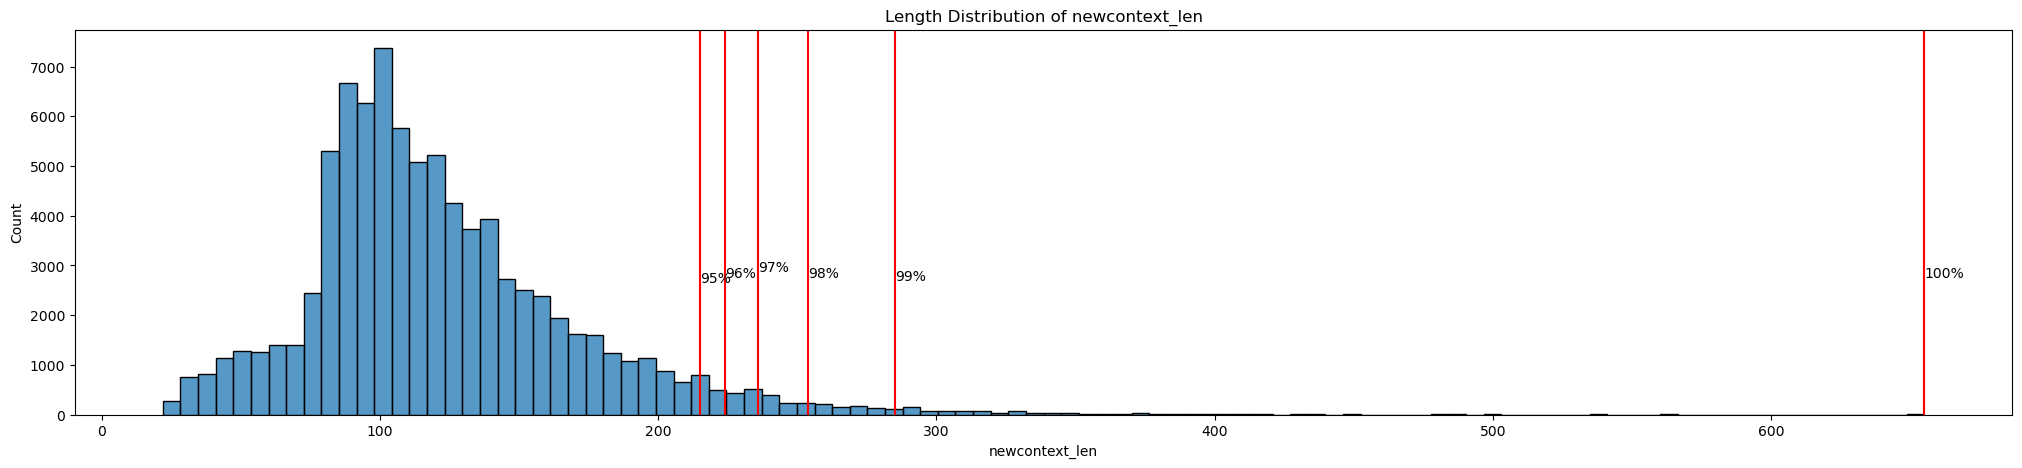

In [11]:
dist_info(df['newcontext_len'], (95,100))


In Order to Cover 100 percent of the data we need to create input length of 653 words which is too much. while just 213 words cover 95 % of the data. 
so lets take 500 words as a context input it will cover99% data.

In [12]:
context_input_len = 500 + 2 # for <SOS> AND <EOS>

In [13]:
# Unique words in  context
# all_words = [i.split() for i in df['newcontext']]

## 2. Questions

In [14]:
df['question_len'].max()

25601

Percent  ::   words  

    95%  ::   17.0 words
    96%  ::   17.0 words
    97%  ::   18.0 words
    98%  ::   19.0 words
    99%  ::   21.0 words


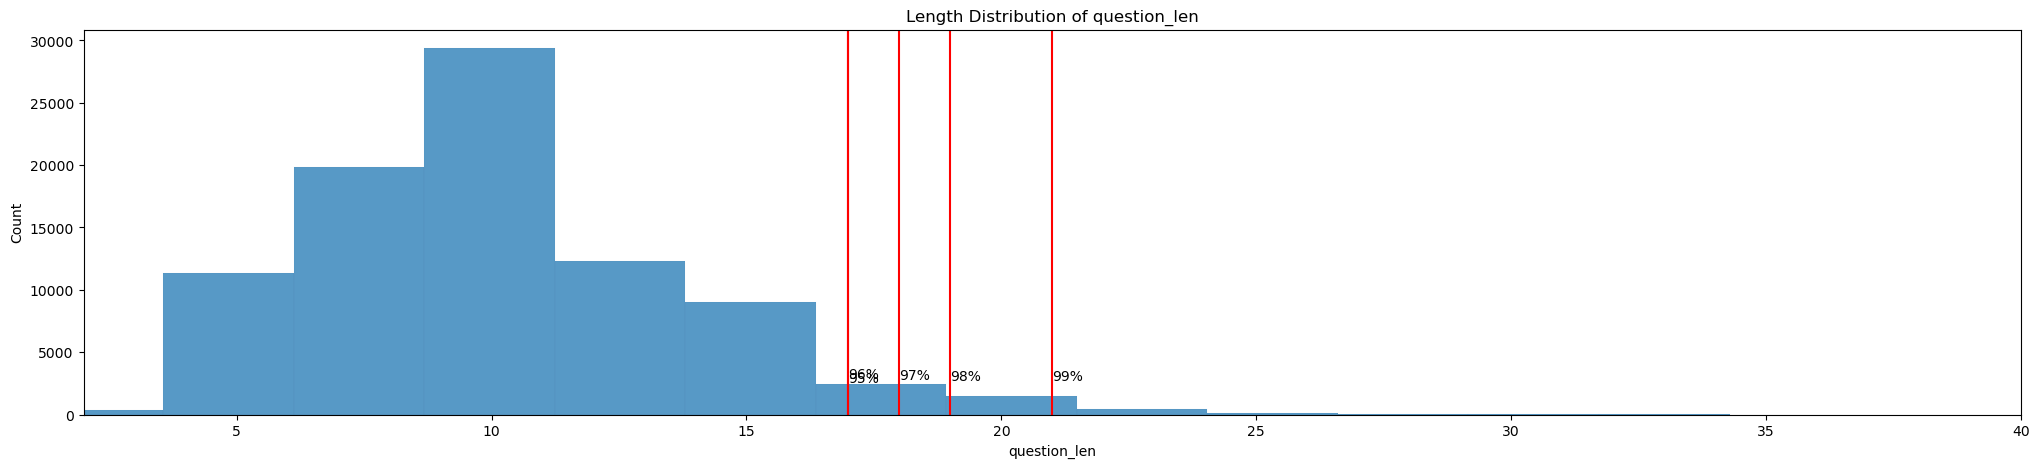

In [15]:
dist_info(x = df['question_len'], r = (95,99), xlim=[2,40], bins = 10000)

clearly there are too much bins 

Similar to context , for input for questions we would go with 50 words , it covers 99% data 

In [16]:
question_inputs_len = 50 + 2 # for <SOS> AND <EOS>

## 3. Answers

Percent  ::   words  

    95%  ::   10.0 words
    96%  ::   11.0 words
    97%  ::   13.0 words
    98%  ::   15.0 words
    99%  ::   18.0 words
   100%  ::   43.0 words


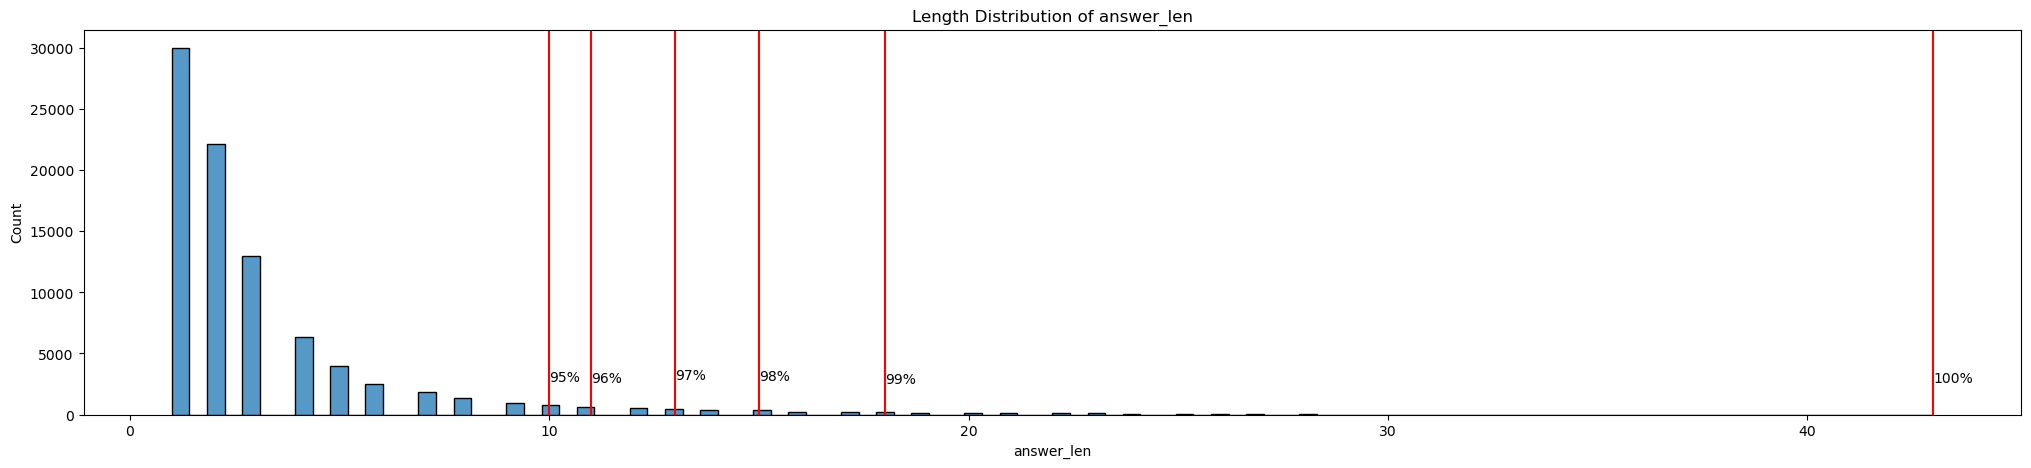

In [17]:
dist_info(df['answer_len'], (95,100))


Similar to context , for input for answers we would go with 50 words , it covers 100% data 

In [18]:
answer_inputs_len = 50 + 2 # for <SOS> AND <EOS>

# Preprocessing TEXT

In [20]:
# FUNCTIONS TO EXPAND CONTRACTIONS

with open('contractions.json') as f:
   contractions_dict = json.load(f)

def cont_to_exp(x):
    x = str(x).lower()
    xsplited = x.split(' ')
    exp_sentence = []
    for s in x.split():
        if s in contractions_dict.keys():
            
            s = contractions_dict.get(s)
        exp_sentence.append(s)
        
    x = ' '.join(exp_sentence)
    return x


In [21]:
# very necessary function you can't tell differece between "’" and "'", I don't even have that symbol in my keyboard
def text_cleaning_apos(text):
    text = str(text)
    text = text.lower()
    text = re.sub("’", "'", text) # removing punctuation
    text = cont_to_exp(text)
    text = re.sub('[#,@,&]', '',text)
    text = re.sub("'s",'', text)
    text = text.replace("?",' ?')
    text = text.replace(".",' .')
    text = text.replace("!",' !')
    # text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    return text

In [22]:
s = 'i am soneone'
s.replace('one', 'body')

'i am sbodybody'

In [23]:
# func 1
df = df.with_columns([
    (pl.col("context").apply(lambda x: text_cleaning_apos(x))),
    (pl.col("questions").apply(lambda x: text_cleaning_apos(x))),
    (pl.col("final_answer").apply(lambda x: text_cleaning_apos(x)))

])

In [24]:
# # func 2
# df = df.with_columns([
#     (pl.col("context").apply(lambda x: cont_to_exp(x))),
#     (pl.col("questions").apply(lambda x: cont_to_exp(x))),
#     (pl.col("final_answer").apply(lambda x: cont_to_exp(x)))

# ])

# Vectorization

In [26]:
from tensorflow.keras.layers import TextVectorization, Embedding

In [27]:
# we will be using universal sentence encoder for vectorization and embedding

In [28]:
embed = hub.KerasLayer("./universal_sentence_encoder")

2023-01-25 16:43:46.854371: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 16:43:46.865747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 16:43:46.866147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 16:43:46.866415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [29]:
Sentences = [
    "How old are you",
    "What is your age",
    "I love to watch Television",
    "I am wearing a wrist watch"
]
embeddings = embed(Sentences)
  

error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
error: Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice
2023-01-25 16:43:52.804060: W tensorflow/core/framework/op_kernel.cc:1768] UNKNOWN: JIT compilation failed.


UnknownError: Exception encountered when calling layer "keras_layer" "                 f"(type KerasLayer).

Graph execution error:

JIT compilation failed.
	 [[{{node EncoderDNN/EmbeddingLookup/EmbeddingLookupUnique/embedding_lookup/mod}}]] [Op:__inference_restored_function_body_4561]

Call arguments received by layer "keras_layer" "                 f"(type KerasLayer):
  • inputs=["'How old are you'", "'What is your age'", "'I love to watch Television'", "'I am wearing a wrist watch'"]
  • training=None